In [1]:
import numpy as np
import gym
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.kernel_approximation import RBFSampler

env = gym.make('MountainCar-v0')

def get_transformer():
    #sampler = RBFSampler(gamma=2.0, n_components=1000, random_state=1234)
    n_components=500
    sampler = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf2", RBFSampler(gamma=2.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])
    
    #from the course solution: 
    scaler = StandardScaler()

    observation_sample = np.vstack([env.observation_space.sample() for i in range(10000)])
    scaler.fit(observation_sample)
    return sampler.fit(scaler.transform(observation_sample)), scaler 

In [ ]:
def G(rewards, gamma, state_estimate):
    result = 0
    factor = 1
    for reward in rewards:
        result += factor *reward
        factor *= gamma
    result += factor*state_estimate
    return result


def decide_action(predictions, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(np.stack(predictions).T)
        
        
def run(env, gamma, epsilon, n_step = 5, render = False):
    observation = env.reset()
    # Transform observation (into higher dimensional feature space)
    transformed_observation = transformer.transform(scaler.transform([observation]))
    
    done = False
    action = None
    total_reward = 0
    
    history = []  #state, reward, is_done, info
    states = []
    actions = []
    
    while(done == False):        

        # Make prediction
        predictions = [m.predict(transformed_observation) for m in models]
        # Choose action & do step
        action = decide_action(predictions, epsilon)
        next_observation, reward, done, info = env.step(action)
        next_transformed_observation = transformer.transform(scaler.transform([next_observation]))
        
        history.append(reward)
        states.append(observation)
        actions.append(action)
        
        rewards = [x for x in history[::-1]][:n_step]
        # Make prediction and calculate value
        next_predictions = [m.predict(next_transformed_observation) for m in models]
        #new_value = reward + gamma * max(next_predictions)
        new_value = G(rewards, gamma, np.max(next_predictions))
        
        # Update models
        #models[action].partial_fit(transformed_observation, [new_value[0]])
        n = min(n_step, len(rewards))
        models[actions[-n]].partial_fit(transformer.transform(scaler.transform([states[-n]]), [new_value])
        #models[action].partial_fit(transformed_observation, [new_value])
        
        # Update observation:
        observation = next_observation
        transformed_observation = next_transformed_observation
        
        if(render):
            env.render()
        total_reward += reward
        
    if render:
        env.close()
    return total_reward 

In [14]:
observation = env.reset()
transformer, scaler = get_transformer()
transformed_observation = transformer.transform([observation])
print('transformed_observation.shape',transformed_observation.shape)

transformed_observation.shape (1, 2000)


In [ ]:
# Initialize model
models = [SGDRegressor() for i in range(env.action_space.n)]
for model in models:
    model.partial_fit(transformed_observation,[0])

# Run many epochs ("learn to drive...")
total_rewards = []
gamma = 0.99
eps_initial = 0.1
eps_decay = 0.001

n_step = 5

for i in range(2000):
    epsilon = eps_initial * np.exp(-eps_decay * i)
    total_rewards.append(run(env, gamma, epsilon, n_step = n_step)) 
    if (i+1)%200 == 0:
        print("Total reward for run ", i+1, " : ", total_rewards[-1])


C:\Users\FlorianHuber\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Total reward for run  200  :  -200.0
Total reward for run  400  :  -200.0
Total reward for run  600  :  -200.0
Total reward for run  800  :  -200.0
Total reward for run  1000  :  -157.0


Text(0.5,1,'Total rewards')

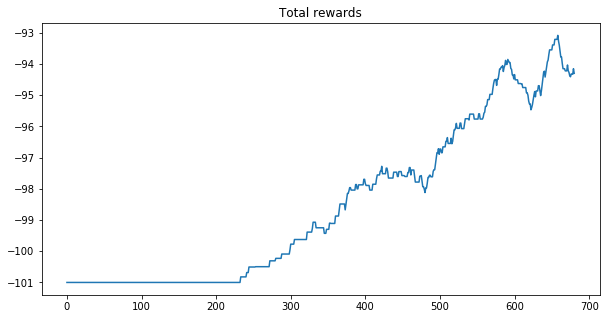

In [10]:
import matplotlib.pyplot as plt

rewards_array = np.array(total_rewards)
avg_reward = []
avg_over = 100
for i in range(len(rewards)):
    avg_reward.append(rewards_array[max(0, i - avg_over):(i +1)].mean())

fig = plt.figure(figsize=(10, 5))
#plt.plot(rewards)
plt.plot(avg_reward)
plt.title("Total rewards")